In [12]:
import torch 
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import time

### Fuente de datos

La base MNIST ("Modified National Institute of Standards and Technology") es un conjunto de datos de imágenes de dígitos escritos a mano. Contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Las imágenes están en escala de grises y tienen un tamaño de 28x28 píxeles.

5


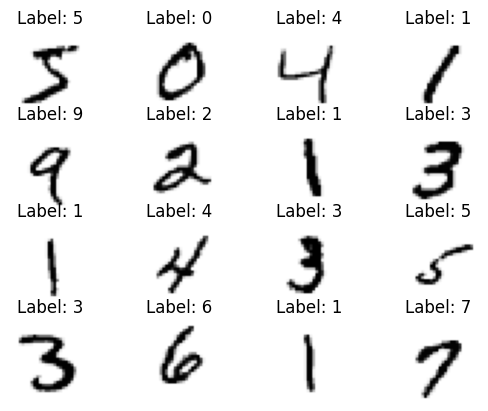

In [13]:
images = torchvision.datasets.MNIST('data', train=True, download=True)
print(images[0][1])

fig, ax = plt.subplots(4, 4)
for (imagen, etiqueta), ax in zip(images, ax.flatten()):
    ax.imshow(imagen, cmap='Greys')
    ax.set_title('Label: %i' % etiqueta)
    ax.axis('off')

### Carga de datos de entrenamiento y prueba

Cargamos las imagenes en tensores de PyTorch

In [14]:
# Cargar los datasets de entrenamiento y prueba

imagenes = torchvision.datasets.MNIST('data', train=True,  download=True, transform=torchvision.transforms.ToTensor())
probar   = torchvision.datasets.MNIST('data', train=False, download=True, transform=torchvision.transforms.ToTensor())

### Definición del dispositivo 

Se elige el dsipositivo de entrenamiento
* cpu : Corre un una pc normal
* cuda : Corre un una placa de video Nvidia 
* mps : Corre en nueral engine de Apple

In [15]:
# Definir el dispositivo
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

# device = "cpu"  # Descomentar para forzar el uso de la CPU
print(f"Las redes funcionaran en {device}")

Las redes funcionaran en mps


### Red Neuronal Simple 

Esta implementación es una red neuronal simple. 
Consiste en un perceptrón para cada dígito

In [ ]:
class Clasificador(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)   # Aplanar la imagen
        x = self.c1(x)
        return x

    def fit(self, dataset, lr=0.1, epochs=10):
        cargador  = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)

        # Mover el modelo al dispositivo
        self.to(device)
        
        # Entrenamiento de la red
        
        self.train()
        for epoch in range(epochs):
            start_time = time.time()
            for images, labels in cargador:
                # Mover imágenes y etiquetas al dispositivo
                images, labels = images.to(device), labels.to(device)
                
                # Adelante + retropropagación + optimización
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            duration = time.time() - start_time  # Calcular la duración de la época
            print(f'- Epoch {epoch+1}, Loss: {loss.item():.4f}, Duration: {duration:3.1f}s')

    def score(self, dataset):
        cargador = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
        # Mover el modelo al dispositivo
        self.to(device)
        
        # Evaluación del modelo
        self.eval()
        correctos = 0
        total = 0
        with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
            for images, labels in cargador:
                # Mover imágenes y etiquetas al dispositivo
                images, labels = images.to(device), labels.to(device)
                
                outputs = self(images)
                _, predicciones = torch.max(outputs, 1)
                correctos += (predicciones == labels).sum().item()
                total += labels.size(0)
        return correctos / total

In [17]:
print(f"▶︎ Red Simple ({device})")

red = Clasificador()
red.fit(imagenes, lr=0.1, epochs=5)

# Evaluar el modelo con el conjunto de prueba
print(f"▪︎ Precisión: {red.score(probar):3.1%}")

▶︎ Red Simple (mps)
- Epoch 1, Loss: 0.4862, Duration: 2.1s
- Epoch 2, Loss: 0.2541, Duration: 1.6s
- Epoch 3, Loss: 0.1743, Duration: 1.6s
- Epoch 4, Loss: 0.2397, Duration: 1.6s
- Epoch 5, Loss: 0.2613, Duration: 1.6s
▪︎ Precisión: 91.9%


### Red Neuronal Multicapa

Esta implementación es una red neuronal multicapa.
Consiste en una capa de entrada de 784 neuronas, dos capas ocultas de 128 y 64 neuronas y una capa de salida de 10 neuronas.

In [ ]:
class ClasificadorProfundo(Clasificador):
    def __init__(self):
        super(ClasificadorProfundo, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)   # Primera capa oculta
        self.fc2 = nn.Linear(128, 64)        # Segunda capa oculta
        self.fc3 = nn.Linear(64, 10)         # Capa de salida

    def forward(self, x):
        x = x.flatten(start_dim=1)   # Aplanar la imagen
        x = torch.relu(self.fc1(x))  # Activación ReLU en la primera capa
        x = torch.relu(self.fc2(x))  # Activación ReLU en la segunda capa
        return self.fc3(x)       

In [19]:
print(f"▶︎ Red Profunda ({device})")
red = ClasificadorProfundo()
red.fit(imagenes, lr=0.1, epochs=5)

# Evaluar el modelo con el conjunto de prueba
print(f"▪︎ Precisión: {red.score(probar):3.1%}")

▶︎ Red Profunda (mps)
- Epoch 1, Loss: 0.2980, Duration: 1.8s
- Epoch 2, Loss: 0.1260, Duration: 1.8s
- Epoch 3, Loss: 0.1364, Duration: 1.8s
- Epoch 4, Loss: 0.0538, Duration: 1.8s
- Epoch 5, Loss: 0.0360, Duration: 1.9s
▪︎ Precisión: 96.6%


### Red Neuronal Convolucional

Esta implementacion es una red neuronal convolucional.
Consiste en una capa de entrada de 1 canal, una capa convolucional de 32 filtros de 3x3, una capa de pooling de 2x2, una capa convolucional de 64 filtros de 3x3, una capa de pooling de 2x2, una capa densa de 128 neuronas y una capa de salida de 10 neuronas.

In [20]:

class RedConvolucional(Clasificador):
    def __init__(self):
        super(RedConvolucional, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # Asumiendo 10 clases para clasificación

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)  # Aplanar
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

In [21]:
print(f"▶︎ Red Convolucional ({device})")
red = RedConvolucional()
red.fit(imagenes, lr=0.1, epochs=5)

# Evaluar el modelo con el conjunto de prueba
print(f"▪︎ Precisión: {red.score(probar):3.1%}")

▶︎ Red Convolucional (mps)
- Epoch 1, Loss: 0.2252, Duration: 3.2s
- Epoch 2, Loss: 0.0675, Duration: 3.5s
- Epoch 3, Loss: 0.0326, Duration: 3.5s
- Epoch 4, Loss: 0.0457, Duration: 3.5s
- Epoch 5, Loss: 0.0968, Duration: 3.6s
▪︎ Precisión: 98.8%
